The goal of this project is to create an e-commerce recommender system using data from the e-commerce website http://ecom.uelstore.com/. Using collaborative filtering, the recommender is created and implemented. This dataset for a product recommendation system contains user ratings for a specific product. Based on how closely related the rated products are, the system will try to recommend products to current users.

In [2]:
#Import libraries
import pandas as pd
from surprise import Reader

##### Customer data

In [5]:
customers=pd.read_json("data/customers.json")

In [6]:
customers.size

1356

In [7]:
customers.head()

,Id,NickName
0,103603,1000kgthanh
1,103760,999999999ok
2,103829,ac7ive
3,1,admin
4,103839,ahkk.nguyen


##### Product data

In [9]:
products=pd.read_json("data/products.json")

In [10]:
products.size

2073

In [11]:
products.head()

,Id,Name,UnitPrice
0,1,Build your own computer,1200.0
1,2,Digital Storm VANQUISH 3 Custom Performance PC,1259.0
2,3,Lenovo IdeaCentre 600 All-in-One PC,500.0
3,4,Apple MacBook Pro 13-inch,1800.0
4,5,Asus N551JK-XO076H Laptop,1500.0


##### Rating data

In [12]:
ratings=pd.read_json("data/ratings.json")

In [13]:
ratings.size

523016

In [14]:
ratings.head()

,CustomerID,ProductID,Rate,CreateDate
0,103416,619,1,2018/01/01 01:36:30
1,103654,411,1,2018/01/01 01:36:35
2,103954,298,3,2018/01/01 01:36:38
3,103672,361,5,2018/01/01 01:37:15
4,103960,536,5,2018/01/01 02:36:25


In [15]:
# Distribution of ratings
print(ratings['Rate'].value_counts())

5    35512
4    30458
1    27876
2    21070
3    15838
Name: Rate, dtype: int64


<AxesSubplot:xlabel='Rate', ylabel='count'>

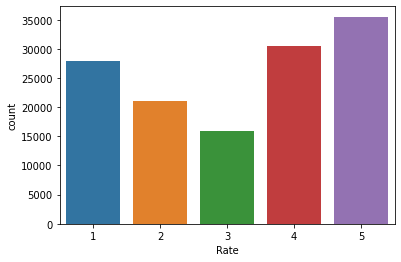

In [25]:
import seaborn as sns
sns.countplot(x=ratings['Rate'])

In [16]:
#Drop the CreateDate column as it is not needed
ratings.drop('CreateDate', inplace=True, axis=1)
ratings.head()

,CustomerID,ProductID,Rate
0,103416,619,1
1,103654,411,1
2,103954,298,3
3,103672,361,5
4,103960,536,5


#### Build recommender system

In [17]:
# Prepare data for surprise: build a Suprise reader object
from surprise import Reader
reader = Reader(rating_scale=(1, 5))

In [18]:
# Load `ratings` into a Surprise Dataset
from surprise import Dataset
rec_data = Dataset.load_from_df(ratings,
                                reader)

In [19]:
# Create a 80:20 train-test split and set the random state to 7
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(rec_data, test_size=.2, random_state=7)


In [20]:
# Use KNNBasic from Surprise to train a collaborative filter
from surprise import KNNBasic
recommender = KNNBasic()
recommender.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [21]:
# Evaluate the recommender system
from surprise import accuracy
predictions = recommender.test(testset)
accuracy.rmse(predictions)

RMSE: 1.1021


1.1021485303764857

In [28]:
testset[0]

(103441, 450, 5.0)

In [29]:
# Prediction on a user 103441 who gave the product 450 a rating of 5
print(recommender.predict('103441', '450').est)

3.1877575212948


In [30]:
#Try other algorithms
from surprise import NormalPredictor
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(),
              KNNBaseline(),KNNWithMeans(), KNNWithZScore(),
              BaselineOnly(), CoClustering()]

In [33]:
print ("Attempting: ", str(algorithms), '\n\n\n')
benchmark=[]    
for algorithm in algorithms:
    print("Starting: " ,str(algorithm))

    algorithm.fit(trainset)

    predictions=algorithm.test(testset)

    score_rmse=accuracy.rmse(predictions)

    metrics=[str(algorithm).split(' ')[0].split('.')[-1],score_rmse]

    benchmark.append(metrics)   

print ('\n\tDONE\n')
report=pd.DataFrame(benchmark,columns=["Algorithm","RMSE"])
report.set_index("Algorithm")
print("-------------------------------------------------")
print(report)

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7ff5ec0aba30>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7ff5ec0ab430>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7ff5ec0abb50>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7ff5ec0ab820>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7ff5ec0ab4f0>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7ff5ec0ab400>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7ff5ec0abdc0>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7ff5ec0aba90>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7ff5ec0b3250>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7ff5ec0aba30>
RMSE: 1.2014
Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7ff5ec0ab430>
RMSE: 1.0598
Starting:  <surprise.prediction_algori

The algorithm `BaselineOnly` has the lowest RMSE score

In [34]:
best_recommender = BaselineOnly()
best_recommender.fit(trainset)

Estimating biases using als...
